# Project: Wrangling and Analyze Data

DEBORAH SANI
PROJECT 2: 

In [58]:
import pandas as pd
import requests
import tweepy
import json
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
weratedogs = pd.read_csv('twitter-archive-enhanced-2.csv')
weratedogs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [59]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image_predictions(8).tsv', mode ='wb') as file:
    file.write(response.content)

In [60]:
#Read TSV file
image_prediction = pd.read_csv('image_predictions(8).tsv', sep='\t' )

In [63]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [64]:
# load tweets status json file after gathering 
tweet_status = pd.read_json('tweet-json.txt', lines = True,encoding='utf-8')
tweet_status.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



Visual Assesment

In [65]:
# Reading gathered files
weratedogs = pd.read_csv('twitter-archive-enhanced-2.csv')
image_prediction = pd.read_csv('image_predictions(8).tsv', sep='\t' )
tweet_status = pd.read_json('tweet-json.txt', lines = True,encoding='utf-8')

In [66]:
weratedogs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [67]:
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [68]:
tweet_status.head()


,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


Programmatic assessment

1.twitter archive

In [69]:
##check datatype and columns number and names
weratedogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [70]:
# initial statistics of data
weratedogs.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [71]:
weratedogs.shape

(2356, 17)

In [72]:
#check duplicate data for tweet_id 
weratedogs.tweet_id.duplicated().sum()

0

In [73]:
# check standard rate denominator sholud be 10
weratedogs[weratedogs['rating_denominator'] >10 ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


In [76]:
# mistyping for rate  numerator
weratedogs[weratedogs['rating_numerator'] >20 ]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [77]:
# check retweet tweets 
weratedogs.retweeted_status_user_id.count()

181

2.image_predictions

In [78]:
##check datatype and columns number and names
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [176]:
# Check duplicate tweet_id
image_prediction.tweet_id.duplicated().sum()

0

In [177]:
#duplicate value @ jpg_url
image_prediction.jpg_url.duplicated().sum()

66

In [178]:
# How Many first  prediction  are actually dogs
image_prediction['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [179]:
## How Many sceond  prediction  are not dogs
(image_prediction.p2_dog==False).sum()

522

In [180]:
## How Many third  prediction  are not dogs
(image_prediction.p3_dog==False).sum()

576

In [181]:
#are there any image lost?
image_prediction.img_num.isnull().sum()

0

3.tweet_status

In [85]:
tweet_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [86]:
##note that not many columns are useful


In [87]:
#how many retweet_status?
tweet_status['retweeted_status'].count()

179

In [88]:
# check duplicate id:

tweet_status.id.duplicated().sum()

0

In [89]:
#check language of tweets
tweet_status[tweet_status.lang !='en'] 
tweet_status.lang.value_counts()

en     2336
und       7
in        3
nl        3
et        1
ro        1
es        1
eu        1
tl        1
Name: lang, dtype: int64

In [90]:
tweet_status.sample(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
2082,NaN,NaN,2015-11-29 03:33:17,"[0, 143]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 670807623365763074, 'id_str'...",1234,False,"Say hello to Andy. He can balance on one foot,...",NaN,...,0.0,NaN,NaN,NaN,546,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1526,NaN,NaN,2016-01-22 01:40:58,"[0, 109]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,1644,False,This is Oddie. He's trying to communicate. 12/...,NaN,...,0.0,NaN,NaN,NaN,573,False,NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
588,NaN,NaN,2016-11-17 17:50:33,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,True,RT @dog_rates: I WAS SENT THE ACTUAL DOG IN TH...,NaN,...,NaN,NaN,NaN,NaN,6478,False,{'created_at': 'Fri Sep 09 18:31:54 +0000 2016...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1965,NaN,NaN,2015-12-06 03:24:51,"[0, 77]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 673342302996340736, 'id_str'...",1362,False,This is Django. He's a skilled assassin pupper...,NaN,...,0.0,NaN,NaN,NaN,649,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
15,NaN,NaN,2017-07-24 00:19:32,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 889278779352338437, 'id_str'...",25652,False,This is Oliver. You're witnessing one of his m...,NaN,...,0.0,NaN,NaN,NaN,5637,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


### Tidiness issues
1.image predictions table should be added to twitter archive table.

2.timestamp change from string to date format day, month , year columns and delete timestamp.
3.Create dog stage column to put all type of dogs classification

# Quality Issues
1.rating_numerator columns mistyping
2.Delete 'timestamp' column
3.Rname for 'text' column
4.rating_denominator' columns standard 10
5.Rname for 'text' column
6.Drop duplicates values from jpg_url
7.Delete columns that won't be used for analysis
8.The prediction dog breeds involve both uppercase and lowercase for the first letter.

**Tweet JSON.


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [134]:
# Make copies of original pieces of data
weratedogs_clean = weratedogs.copy()
image_clean = image_prediction.copy()
tweet_status_clean = tweet_status.copy()

In [135]:
weratedogs_clean.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Issue #1:

#### Define:

Keep original ratings (no retweets) that have images

#### Code

In [136]:
#Delete retweets by filtering the NaN of retweeted_status_user_id
weratedogs_clean = weratedogs_clean[pd.isnull(weratedogs_clean['retweeted_status_user_id'])]

#### Test

In [137]:
#confirm changes
print(sum(weratedogs_clean.retweeted_status_user_id.value_counts()))

0


### Issue #2:

#### Define

Drop columns not that are not needed for this analysis

#### Code

In [138]:
#drop columns
weratedogs_clean = weratedogs_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                            'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls'], 1)

#### Test

In [139]:
weratedogs_clean.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


# Define

Fix error Datatypes

# code

In [140]:
# Convert tweet_id to str from twitter_archive, image_prediction, twitter_data tables.
weratedogs_clean.tweet_id = weratedogs_clean.tweet_id.astype(str)
image_clean.tweet_id = image_clean.tweet_id.astype(str)
weratedogs_clean.tweet_id = weratedogs_clean.tweet_id.astype(str)

# convert timestamp to datetime
weratedogs_clean.timestamp = pd.to_datetime(weratedogs_clean.timestamp)

# convert source to category datatype
weratedogs_clean.source = weratedogs_clean.source.astype("category")

# test

In [141]:
#confirm changes
weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null category
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: category(1), datetime64[ns](1), int64(2), object(7)
memory usage: 189.2+ KB


# define

Correct numerators with decimals

# code

In [142]:
# check to see if some columns were not extracted properly to capture decimals
with pd.option_context('max_colwidth', 200):
    display(weratedogs[weratedogs['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


# define

Now let's fix the affected rows that didnt extract properly.

# code

In [143]:
# convert to float datatype
weratedogs_clean[['rating_numerator', 'rating_denominator']] = weratedogs_clean[['rating_numerator','rating_denominator']].astype(float)

#update values
weratedogs_clean.loc[(weratedogs_clean.tweet_id == 883482846933004288), 'rating_numerator'] = 13.5
weratedogs_clean.loc[(weratedogs_clean.tweet_id == 786709082849828864), 'rating_numerator'] = 9.75
weratedogs_clean.loc[(weratedogs_clean.tweet_id == 778027034220126208), 'rating_numerator'] = 11.27
weratedogs_clean.loc[(weratedogs_clean.tweet_id == 681340665377193984), 'rating_numerator'] = 9.5
weratedogs_clean.loc[(weratedogs_clean.tweet_id == 680494726643068929), 'rating_numerator'] = 11.26

# test

In [144]:
#confirm changes
with pd.option_context('max_colwidth', 200):
    display(weratedogs_clean[weratedogs_clean['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0,10.0
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0,10.0
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0


# define

let's find Incorrect dog names.

In [145]:
weratedogs_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl',
       'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty',
       'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven',
       'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante',
       'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash',
       'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie',
       'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha',
       'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jer

code

In [146]:
weratedogs_clean['name'][weratedogs_clean['name'].str.match('[a-z]+')] = 'None'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


 Test

In [147]:
# confirm changes
weratedogs_clean.name.value_counts()

None        784
Lucy         11
Charlie      11
Cooper       10
Oliver       10
Tucker        9
Penny         9
Winston       8
Sadie         8
Lola          8
Toby          7
Daisy         7
Bailey        6
Stanley       6
Oscar         6
Bo            6
Koda          6
Bella         6
Jax           6
Bentley       5
Milo          5
Louis         5
Leo           5
Buddy         5
Chester       5
Scout         5
Dave          5
Rusty         5
Jeffrey       4
Winnie        4
           ... 
Brandi        1
Fwed          1
Perry         1
Tuck          1
Canela        1
Pipsy         1
Striker       1
Autumn        1
Ridley        1
Blu           1
Tobi          1
Brat          1
Chesney       1
Bones         1
Julio         1
Brady         1
Aldrick       1
Duchess       1
Snickers      1
Poppy         1
Katie         1
Rilo          1
Tonks         1
Mark          1
Mosby         1
Loomis        1
O             1
Jackie        1
Ruffles       1
Ambrose       1
Name: name, Length: 931,

 define

Some records have more than one dog stage

 code

In [148]:
weratedogs_clean['add_all'] = weratedogs_clean.doggo + weratedogs_clean.floofer + weratedogs_clean.pupper + weratedogs_clean.puppo

In [149]:
weratedogs_clean.add_all.value_counts()

NoneNoneNoneNone        1831
NoneNonepupperNone       224
doggoNoneNoneNone         75
NoneNoneNonepuppo         24
doggoNonepupperNone       10
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: add_all, dtype: int64

In [150]:
# create function to check dog stages
def check_stages(weratedogs):
    if weratedogs['add_all'].count('None') == 2:
        return 'Multiple' #this means it has more than one dog stage
    else:
        if weratedogs['add_all'].count('doggo') == 1:
            return 'Doggo'
        elif weratedogs['add_all'].count('floofer') == 1:
            return 'Floofer'
        elif weratedogs['add_all'].count('pupper') == 1:
            return 'Pupper'
        elif weratedogs['add_all'].count('puppo') == 1:
            return 'Puppo'
        else:
            return 'None'

weratedogs_clean['dog_stage'] = weratedogs_clean.apply(check_stages, axis=1)

test

In [151]:
weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null category
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
add_all               2175 non-null object
dog_stage             2175 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), object(9)
memory usage: 223.2+ KB


 test

In [152]:
 weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null category
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
add_all               2175 non-null object
dog_stage             2175 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), object(9)
memory usage: 223.2+ KB


 define

drop unused column

 code

In [153]:
# drop columns
weratedogs_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'add_all'], axis=1, inplace=True)

In [154]:
# convert to category datatype 
weratedogs_clean.dog_stage = weratedogs_clean.dog_stage.astype('category')

test

In [155]:
#confirm changes
weratedogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null category
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
dog_stage             2175 non-null category
dtypes: category(2), datetime64[ns](1), float64(2), object(3)
memory usage: 123.6+ KB


In [158]:
# matched deleted columns
weratedogs_clean.dog_stage.value_counts() 

None        1831
Pupper       224
Doggo         75
Puppo         24
Multiple      12
Floofer        9
Name: dog_stage, dtype: int64

In [159]:
weratedogs_clean.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null datetime64[ns]
source                2175 non-null category
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
dog_stage             2175 non-null category
dtypes: category(2), datetime64[ns](1), float64(2), object(3)
memory usage: 123.6+ KB


define

 Source column is in HTML-formatted string, not a normal string
 
   
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html
    
    https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column?noredirect=1

code

In [160]:
#extract values
weratedogs_clean.source = weratedogs_clean.source.str.extract('>([\w\W\s]*)<', expand=True) 

 test

In [161]:
#confirm changes
weratedogs_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

In [196]:
image_clean = image_prediction.copy()

In [198]:
image_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


Define

change name for p1,p2 and p3 to Breed_probability1,Breed_probability2,Breed_probability3......

Code

In [199]:
#rename undescriptive columns name
image_clean=image_clean.rename(columns={'p1':'first_prediction', 'p1_conf': 'first_confidence', 'p1_dog': 'first_dog',
                                  'p2': 'second_prediction', 'p2_conf': 'second_confidence', 'p2_dog': 'second_dog',
                                  'p3': 'third_prediction', 'p3_conf': 'third_confidence', 'p3_dog': 'third_dog'})

Test

In [200]:
#Testing columns name 
list(image_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'first_prediction',
 'first_confidence',
 'first_dog',
 'second_prediction',
 'second_confidence',
 'second_dog',
 'third_prediction',
 'third_confidence',
 'third_dog']

Define

Delete duplicate values

Code

In [201]:
#drop duplicate value
image_clean=image_clean.drop_duplicates(subset=['jpg_url'], keep='first')

Test

In [203]:
# testing for duplicate values in jpg_url column
image_clean.jpg_url.duplicated().sum()

0

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [204]:
weratedogs_clean.to_csv('twitter_archive_master.csv', index=False) 

# Save cleaned data

In [205]:
weratedogs_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [206]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [207]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 8 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null float64
rating_denominator    2175 non-null float64
name                  2175 non-null object
dog_stage             2175 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 136.0+ KB


Q1: Most used Twitter Source

In [208]:
source = twitter_archive_master['source'].value_counts()
source

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

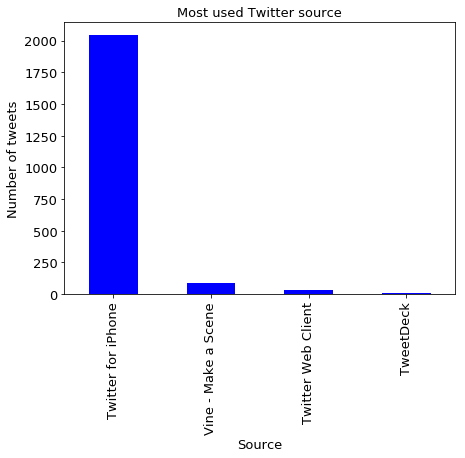

In [209]:
#plot
g_bar = source.plot.bar(color = 'blue', fontsize = 13)

#figure size(width, height)
g_bar.figure.set_size_inches(7, 5);

#Add labels
plt.title('Most used Twitter source', color = 'black', fontsize = '13')
plt.xlabel('Source', color = 'black', fontsize = '13')
plt.ylabel('Number of tweets', color = 'black', fontsize = '13');

### Insights:
1.Most used Twitter Source

2.Most popular dog name

3.High popular dog stage count tweets

Q2: Most popular dog name

In [210]:
pname = pname = twitter_archive_master.name.value_counts()[1:10] 

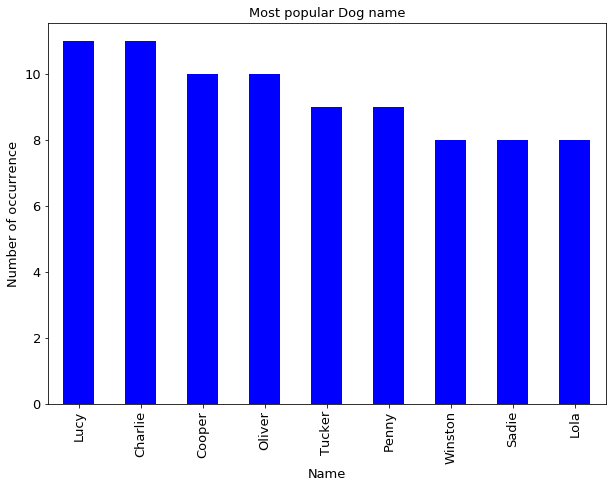

In [211]:
#plot
g_bar = pname.plot.bar(color = 'blue', fontsize = 13)

#figure size(width, height)
g_bar.figure.set_size_inches(10, 7);

#Add labels
plt.title('Most popular Dog name', color = 'black', fontsize = '13')
plt.xlabel('Name', color = 'black', fontsize = '13')
plt.ylabel('Number of occurrence', color = 'black', fontsize = '13');

Charlie and Lucy are the most popular dog name with 12

### Visualization

In [212]:
weratedogs_clean.to_csv('twitter_archive_master.csv', index=False)

In [213]:
master_clean=pd.read_csv('twitter_archive_master.csv')

In [226]:
list(master_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

Q3.High popular dog stage count tweets

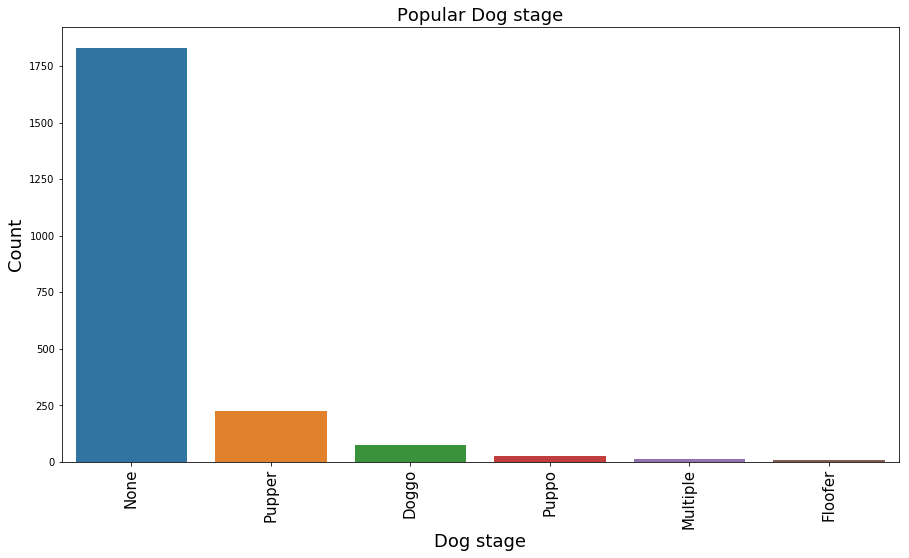

In [227]:
plt.figure(figsize = (15,8))
ax = sb.barplot(x = master_clean['dog_stage'].value_counts()[0:10].index,
            y =master_clean['dog_stage'].value_counts()[0:10],
            data = master_clean);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 15);
plt.xlabel("Dog stage",fontsize = 18);
plt.ylabel("Count",fontsize = 18);
plt.title("Popular Dog stage",fontsize = 18);